In [1]:
import os
import psycopg
import pandas as pd
from tqdm import tqdm
from tqdm import tqdm
import binascii
import polars as pl
import numpy as np
import psycopg

import matplotlib.colors as mcolors    
from matplotlib import pyplot as plt

from tools.utils import basicconfig
from tools.utils.settings import get_all_paths

In [2]:
from tools.utils.datalake import SimpleDataLakeHelper

dataset = 'wikiturlsnap'
size = 'standard'
datalake_location = 'mongodb'

dlh = SimpleDataLakeHelper(datalake_location, dataset, size)

## In the best returned results, how are distributed Jaccard, Containment and other metrics w.r.t. the area ratio?

In [ ]:
test_name, dataset, k, q = 'a_test', 'wikiturlsnap', 10, '100K'
_, _, _, _, _, _, results_extr_dir, _, _, _ = get_all_paths(test_name, dataset, k, q)
extrres = pl.read_csv(f'{results_extr_dir}/final_results_k{k}_q{q}.csv')

In [ ]:
measure_data = extrres.select(['area_ratio', 'jaccard_sim', 'multi_jaccard_sim', 'containment', 'overlap_set_sim'])

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
stat = []
sample_size = 10000
for (lb, ub) in [(0, 0.4), (0.4, 0.8), (0.8, 1.1)]:
    
    data = measure_data.filter((lb <= pl.col('area_ratio')) & (pl.col('area_ratio') < ub)).sample(sample_size).to_numpy()
    area_ratio, js, mjs, c, osm = data[:, 0], data[:, 1], data[:, 2], data[:, 3], data[:, 4]

    l = []
    for m in [js, mjs * 2, c, osm]:
        x = m > area_ratio * 1.0  # 5% error
        l.append((np.mean(x), np.std(x)))

    stat += [((lb, ub), l)]
    
    for ax, m, mlabel in zip(axes, [js, mjs, c, osm], ['jaccard', 'multi-jaccard', 'containmnent', 'overlap set']):
        ax.scatter(area_ratio, m, s=0.1)
        ax.set_title(mlabel)
        ax.set_ylim((0, 1))
        ax.set_xlabel('Largest overlap\n(normalised by smaller table area)')
        ax.plot([0, 1] if mlabel != 'multi-jaccard' else [0, 0.5], color='r', linewidth=0.4)

In [ ]:
data = [y for x in stat for y in x[1]]

In [ ]:
for i in range(4):
    x = [i, i+0.2, i+0.4]
    y = [w[0] for z in stat for w in z[1]][i::4]
    yerr = [w[1] for z in stat for w in z[1]][i::4]
    for j in range(3):
        plt.errorbar(
            x[j], y[j], yerr[j],
            fmt='^',
            linestyle='',
            capsize=3,
            color=list(mcolors.TABLEAU_COLORS.keys())[j]
            # marker='d',
        )
plt.ylim((0, 1))
plt.xticks([0.2, 1.2, 2.2, 3.2], ['jaccard', 'multi-jaccard', 'containment', 'overlap set'])
plt.suptitle('Media e stdev del numero di elementi superiori all\'area ratio,\nsuddivisi per metrica e classe di area ratio [0,0.4), [0.4,0.8), [0.8,1]')
plt.show()

In [ ]:
methods = basicconfig.algmodeconfig
colors = list(mcolors.TABLEAU_COLORS.keys())
methods = {m: c for m, c in zip(methods, colors[:len(methods)])}

sample_size = 5000
fig, ax = plt.subplots(1, extrres.select(['algorithm', 'mode']).unique().shape[0], figsize=(15,5))
for i, ((alg, mode), data) in enumerate(extrres.sample(sample_size).select(['algorithm', 'mode', 'area_ratio', 'jaccard_sim']).group_by('algorithm', 'mode')):
    data = data.select('area_ratio', 'jaccard_sim')
    data = data.to_numpy()
    area_ratio, js = data[:, 0], data[:, 1]
    ax[i].scatter(area_ratio, js, s=0.5, label=f'{alg}-{mode}', color=methods[(alg, mode)])
    ax[i].set_title(f"{alg}-{mode}")
    ax[i].plot([0, 1], color='r', linewidth=0.4)

plt.show()

## Information from the JOSIE PostgreSQL tables

In [3]:
_dbconn = psycopg.connect(f"port=5442 host=/tmp dbname=nanni")

Statistics about the mean, stdev, meadian of the posting lists

In [4]:
_dbconn

<psycopg.Connection [IDLE] (port=5442 database=nanni) at 0x7f0af95dbeb0>

In [5]:
def joise_invlist_stat(test_name, dataset, mode):
    res = _dbconn.execute(f"SELECT frequency FROM {test_name}_d{dataset}_m{mode}_inverted_lists;")
    res = [r[0] for r in res.fetchall()]
    print(test_name, dataset, mode)
    print(f'count:  {len(res)}')
    print(f'mean:   {np.mean(res)}')
    print(f'stddev: {np.std(res)}')
    print(f'median: {np.median(res)}')
    print(f'min:    {np.min(res)}')
    print(f'max:    {np.max(res)}')

In [ ]:
joise_invlist_stat('main', 'santoslarge', 'set')

In [ ]:
joise_invlist_stat('main', 'gittables', 'bag')

Get the N most frequent tokens and their original string

In [6]:
def most_frequent_tokens(test_name, dataset, mode, N):
    res = _dbconn.execute(f"SELECT raw_token, frequency FROM {test_name}_d{dataset}_m{mode}_inverted_lists ORDER BY frequency DESC LIMIT {N};")

    r = [(binascii.unhexlify(rt).decode('utf-8'), f) for (rt, f) in res]

    tlj = max(len(x[0]) for x in r)
    flj = max(len(str(x[1])) for x in r)

    for rt, f in r:
        print(rt.ljust(tlj), str(f).rjust(flj))
    return r

In [7]:
mft = most_frequent_tokens('main', 'gittables', 'set', 50)

tptacek         37003
jacquesm        34426
jrockway        34011
davidw          31883
patio11         30174
Tichy           28124
pg              27750
gaius           24089
tokenadult      23915
A               23814
rbanffy         23076
edw519          22665
B               22070
vaksel          21854
yummyfajitas    21471
sd              21341
nostrademons    21157
sv              21074
rms             21009
philwelch       20958
b               20748
aa              20645
gojomo          20638
%               20401
anigbrowl       20345
ars             19837
+               19763
bootload        19651
axod            19568
swombat         19272
eru             18891
F               18839
Uh-huh/UH ./.   18777
Uh-huh. /       18764
Yeah/UH ./.     18698
Yeah. /         18595
DanielBMarkham  18317
ba              18079
cwan            18073
C               17934
Yeah/UH ,/,     17922
petercooper     17762
Yeah, /         17753
qy              17679
mahmud          17331
_delirium 

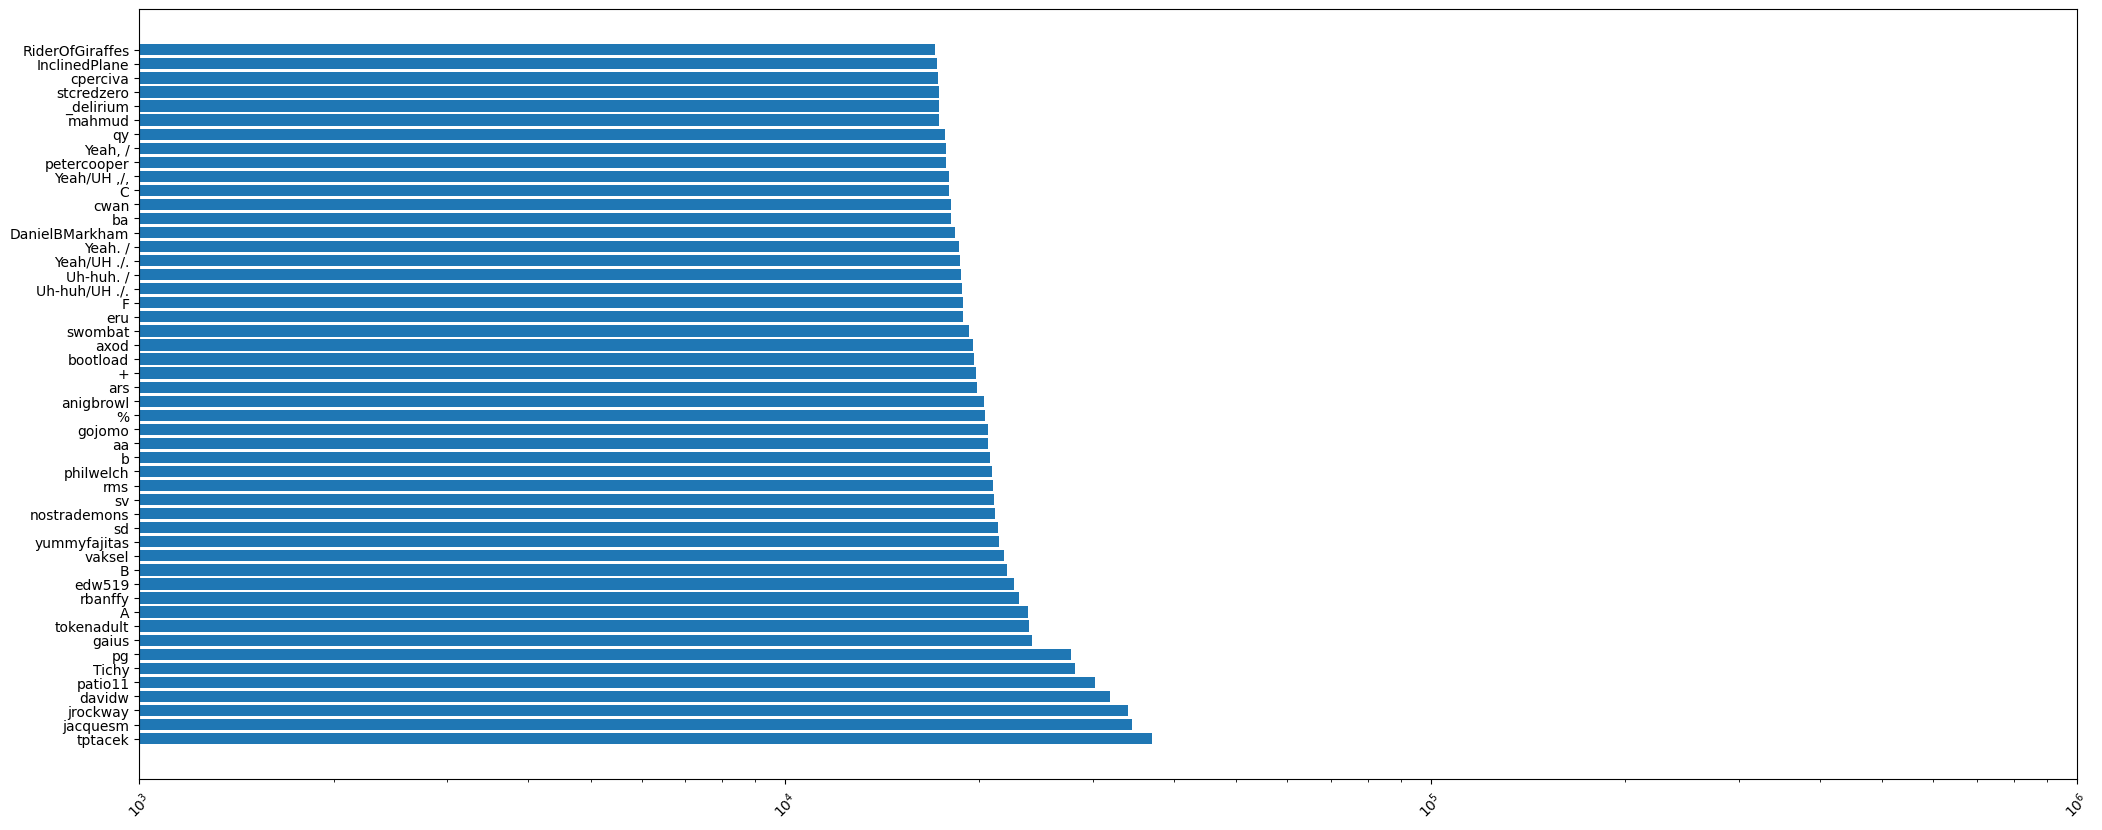

In [12]:
tok = [r[0] for r in mft]
f = [r[1] for r in mft]

plt.barh(tok, f)
plt.rcParams["figure.figsize"] = (10,20)
plt.xscale('log')
locs, labels = plt.xticks()
plt.xticks(locs, labels, rotation=45)
plt.show()
# plt.savefig('comment_story_freq.png', bbox_inches='tight')

In [15]:
mft = most_frequent_tokens('main', 'wikiturlsnap', 'set', 50)

Notes         161479
Name          146915
Title         113378
Date          109959
Team           96162
Total          78907
1              77349
4              71275
Player         70329
Result         69811
—              69416
2              68234
5              62201
Role           62187
3              60318
6              58144
Score          54925
Country        53585
Club           53517
Season         50724
Time           50721
Event          48974
0              46995
7              46181
Nationality    45028
Position       44469
8              42585
Location       42193
Party          40633
10             40439
2nd            40078
-              39464
3rd            39367
1st            38984
Athlete        38968
League         37609
4th            36215
Rank           36014
9              35439
–              34869
Winner         34093
5th            34035
11             33257
12             32745
Venue          32360
Opponent       31392
6th            30757
Year         

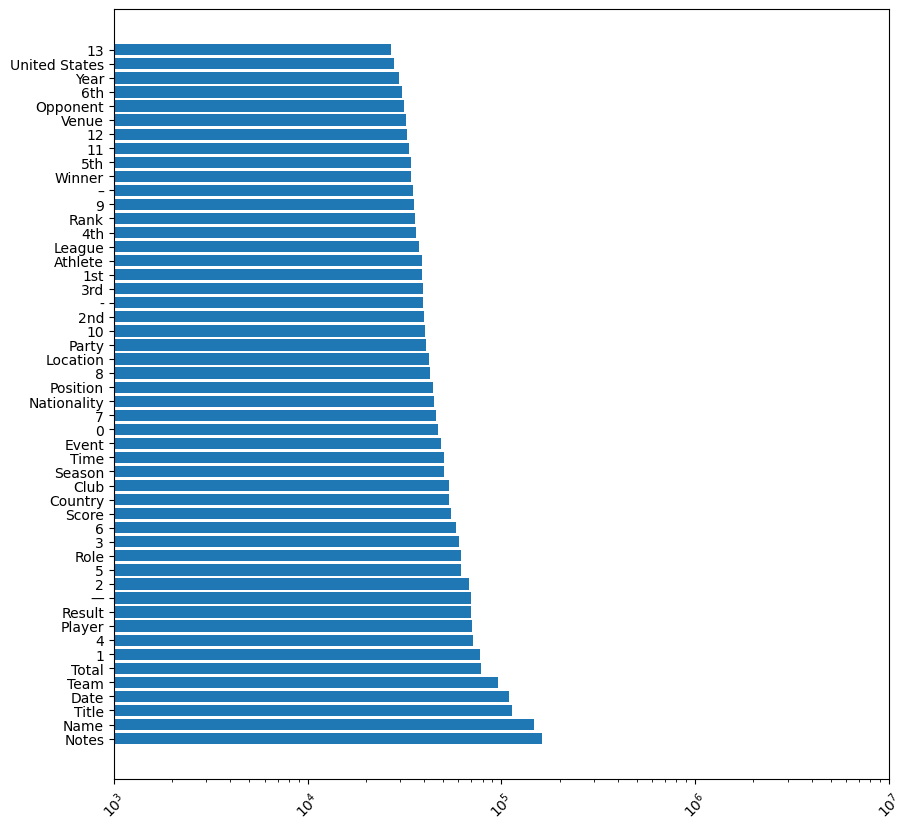

In [20]:
tok = [r[0] for r in mft]
f = [r[1] for r in mft]

plt.barh(tok, f)
plt.rcParams["figure.figsize"] = (10,20)
plt.xscale('log')
locs, labels = plt.xticks()
plt.xticks(locs, labels, rotation=45)
plt.show()
# plt.savefig('comment_story_freq.png', bbox_inches='tight')

In [ ]:
_dbconn.close()

## How are divided the queries, w.r.t. their table size?

In [3]:
thresholds = list(range(0, 10 ** 4 + 1, 100)) # [10, 100, 200, 300, 400, 500, 600, 700, 1000, 2000, 5000, 10000]

bins=thresholds[1:]

In [5]:
test_name, dataset, k, q = 'main', 'wikiturlsnap', 20, '50K'
_, _, _, _, _, _, results_extr_dir, _, _, _ = get_all_paths(test_name, dataset, k, q)
extrres = pd.read_csv(f'{results_extr_dir}/final_results_k{k}_q{q}.csv').dropna()

extrres = extrres[['query_id', 'bag_size_q']].drop_duplicates()
tot = extrres.shape[0]
r = []


for i in range(len(thresholds)):    
    if i < len(thresholds) - 1:
        s = extrres[(extrres['bag_size_q'] >= thresholds[i]) & (extrres['bag_size_q'] < thresholds[i + 1])].shape[0]
        r.append([f"[{thresholds[i]},{thresholds[i + 1]})", round(s / tot, 5)])
    else:
        s = extrres[(extrres['bag_size_q'] >= thresholds[i])].shape[0]
        r.append([f"[{thresholds[i]},inf)", round(s / tot, 5)])
    # print(f"{thresholds[i]}<=X<{thresholds[i + 1]}:\t{s}\t{s * 100 / tot}")

In [ ]:
extrres.hist('bag_size_q', bins=bins, width=50)
# plt.xscale('log')
plt.yscale('log')

In [6]:
test_name, dataset, k, q = 'main', 'gittables', 20, '50K'
_, _, _, _, _, _, results_extr_dir, _, _, _ = get_all_paths(test_name, dataset, k, q)
extrres = pd.read_csv(f'{results_extr_dir}/final_results_k{k}_q{q}.csv').dropna()

extrres = extrres[['query_id', 'bag_size_q']].drop_duplicates()
tot = extrres.shape[0]
r1 = []


for i in range(len(thresholds)):    
    if i < len(thresholds) - 1:
        s = extrres[(extrres['bag_size_q'] >= thresholds[i]) & (extrres['bag_size_q'] < thresholds[i + 1])].shape[0]
        r1.append([f"[{thresholds[i]},{thresholds[i + 1]})", round(s / tot, 5)])
    else:
        s = extrres[(extrres['bag_size_q'] >= thresholds[i])].shape[0]
        r1.append([f"[{thresholds[i]},inf)", round(s / tot, 5)])
    # print(f"{thresholds[i]}<=X<{thresholds[i + 1]}:\t{s}\t{s * 100 / tot}")

In [ ]:
extrres.hist('bag_size_q', bins=bins, width=50)
# plt.xscale('log')
plt.yscale('log')

In [7]:
test_name, dataset, k, q = 'main', 'santoslarge', 20, '500'
_, _, _, _, _, _, results_extr_dir, _, _, _ = get_all_paths(test_name, dataset, k, q)
extrres = pd.read_csv(f'{results_extr_dir}/final_results_k{k}_q{q}.csv').dropna()

extrres = extrres[['query_id', 'bag_size_q']].drop_duplicates()
tot = extrres.shape[0]
r2 = []

for i in range(len(thresholds)):    
    if i < len(thresholds) - 1:
        s = extrres[(extrres['bag_size_q'] >= thresholds[i]) & (extrres['bag_size_q'] < thresholds[i + 1])].shape[0]
        r2.append([f"[{thresholds[i]},{thresholds[i + 1]})", round(s / tot, 5)])
    else:
        s = extrres[(extrres['bag_size_q'] >= thresholds[i])].shape[0]
        r2.append([f"[{thresholds[i]},inf)", round(s / tot, 5)])
    # print(f"{thresholds[i]}<=X<{thresholds[i + 1]}:\t{s}\t{s * 100 / tot}")

In [ ]:
extrres.hist('bag_size_q', bins=thresholds[1:], width=50)
plt.yscale('log')

In [8]:
# r.append([0, 0])
# r1.append([0, 0])
len(r), len(r1), len(r2)

(101, 101, 101)

In [ ]:
r2[-2] = ['[9500,10000)', 0]
r2[-2], r2[-1]

In [ ]:
r = r[:-1]
r2 = r2[:-1] 
r1 = r1[:-1]

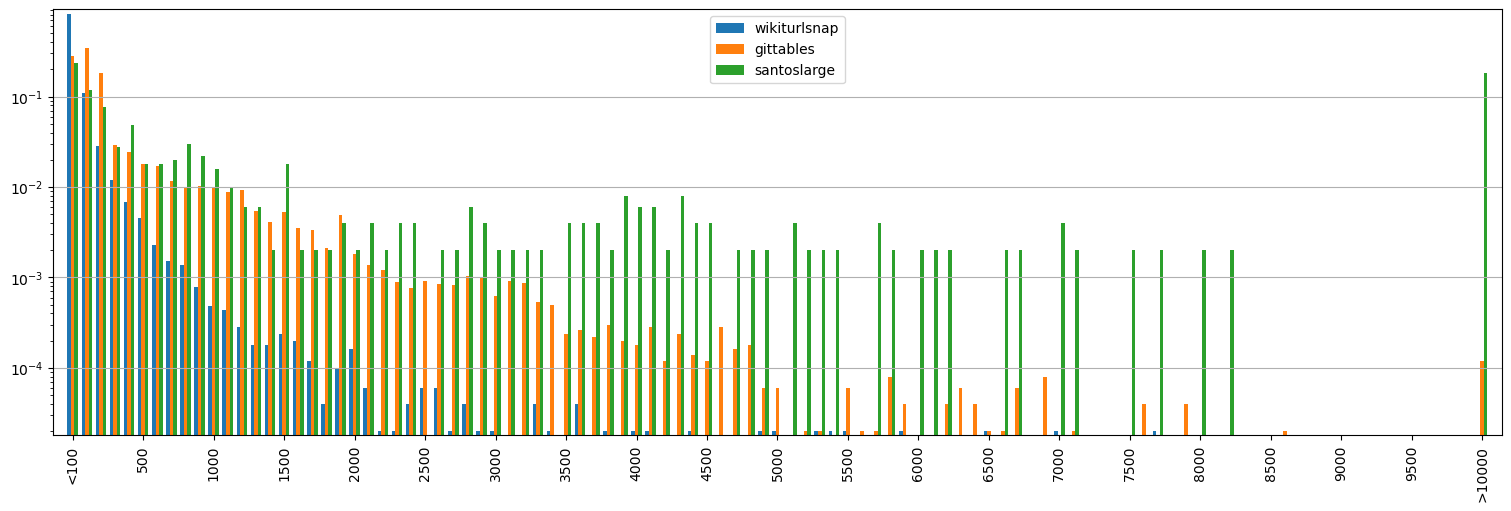

In [11]:
from matplotlib.colors import TABLEAU_COLORS as tcolors

width = 0.25  # the width of the bars
multiplier = -0.5

x = np.arange(len(r)) 
fig, ax = plt.subplots(layout='constrained', figsize=(15, 5))

for data, label, c in zip([r, r1, r2], ['wikiturlsnap', 'gittables', 'santoslarge'], [tcolors['tab:blue'], tcolors['tab:orange'], tcolors['tab:green']]):
    offset = width * multiplier
    rects = ax.bar(x + offset, [y[1] for y in data], align='edge', label=label, width=width)
    # ax.bar_label(rects, padding=2)
    multiplier += 1

ax.legend()
ax.grid(axis='y')
ax.margins(0.01)
ax.set_xticks(np.arange(0, len(r), 5) + width, range(0, 10 ** 4 + 1, 500))

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = '<100'
labels[-1] = '>10000'

ax.set_xticklabels(labels)

ax.tick_params(axis='x', rotation=90)
ax.set_yscale('log')

## How many queries don't have exactly K returned tables for each algorithm/method?

In [ ]:
test_name, dataset, k, q = 'a_test', 'wikiturlsnap', 10, '50K'
_, _, _, _, _, _, results_extr_dir, _, _, _ = get_all_paths(test_name, dataset, k, q)
extrres = pd.read_csv(f'{results_extr_dir}/final_results_k10_q50K.csv').dropna()

In [ ]:
bad_groups = []
for query_id, q_group in tqdm(extrres.groupby('query_id'), total=extrres['query_id'].unique().shape[0]):
    for (alg, mode), data in q_group.groupby(['algorithm', 'mode']):
        if data.shape[0] < 10:
            bad_groups.append(query_id)
            break

In [ ]:
len(bad_groups) * 100 / 50000

## How many failures has SLOTH done in computing the largest overlap?

During the extraction phase, whenever a failure has occurred, the relative pair \<query_id, result_id\> has been stored with a overlap value of -1

In [ ]:
dataset = 'gittables'
size = 'standard'
blacklist = ['story']

table_name = f'results_d{dataset}_s{size}'
if len(blacklist) >= 1:
    table_name += '_blacklist'
_dbconn = psycopg.connect(f"port=5442 host=/tmp dbname=nanni")
failures = _dbconn.execute(f"SELECT COUNT(*) FROM {table_name} WHERE sloth_overlap = -1").fetchone()[0]
total_computed_overlaps = _dbconn.execute(f"SELECT COUNT(*) FROM {table_name}").fetchone()[0]

total_computed_overlaps, failures, failures * 100 / total_computed_overlaps

## Storage space of FAISS indexes

In [ ]:
import faiss

faiss_path = '/data4/nanni/tesi-magistrale/data/tests/main/wikiturlsnap/embedding/col_idx_mft.index'

index = faiss.read_index(faiss_path)

In [ ]:
nvectors = index.ntotal
nvectors

In [ ]:
embedding_size = 300
vector_size = 4 * embedding_size + 8
vector_size_hnsw = 4 * embedding_size + 32 * 4 * 2

vector_space = vector_size * nvectors
vector_space_hnsw = vector_size_hnsw * nvectors

vector_space, vector_space / (1024 ** 3), os.path.getsize(faiss_path) / (1024 ** 3), vector_space_hnsw / (1024 ** 3)

## Mean and StdDev for single query time

In [6]:
paths = get_all_paths('main', 'wikiturlsnap', 20, '50K')
results_dir = paths[5]
for res_file in os.listdir(results_dir):
    if '.raw' in res_file: continue
    print(res_file)
    df = pl.read_csv(f'{results_dir}/{res_file}')

    # print(df.schema)
    print('mean: ', round(df.select('duration').mean().rows()[0][0], 3), 'stdev: ', round(df.select('duration').std().rows()[0][0], 3))
    print()

aembedding_mftdist.csv
mean:  0.002 stdev:  0.0

ajosie_mbag.csv
mean:  0.2 stdev:  0.29

ajosie_mset.csv
mean:  0.158 stdev:  0.174

alshforest_mbag.csv
mean:  0.002 stdev:  0.012

alshforest_mset.csv
mean:  0.002 stdev:  0.012

aembedding_mft.csv
mean:  0.0 stdev:  0.0



In [11]:
paths = get_all_paths('main', 'santoslarge', 10, '500')
results_dir = paths[5]
for res_file in os.listdir(results_dir):
    if '.raw' in res_file: continue
    print(res_file)
    df = pl.read_csv(f'{results_dir}/{res_file}')

    # print(df.schema)
    print('mean: ', round(df.select('duration').mean().rows()[0][0], 3), 'stdev: ', round(df.select('duration').std().rows()[0][0], 3))
    print()

ajosie_mbag.csv
mean:  1.019 stdev:  3.639

ajosie_mset.csv
mean:  0.089 stdev:  0.187

alshforest_mbag.csv
mean:  0.001 stdev:  0.0

alshforest_mset.csv
mean:  0.001 stdev:  0.0

aembedding_mft.csv
mean:  0.0 stdev:  0.001



## Progress of bag mode size

How does the number of elements in bag mode increase in a range of tables (e.g. 10K)?

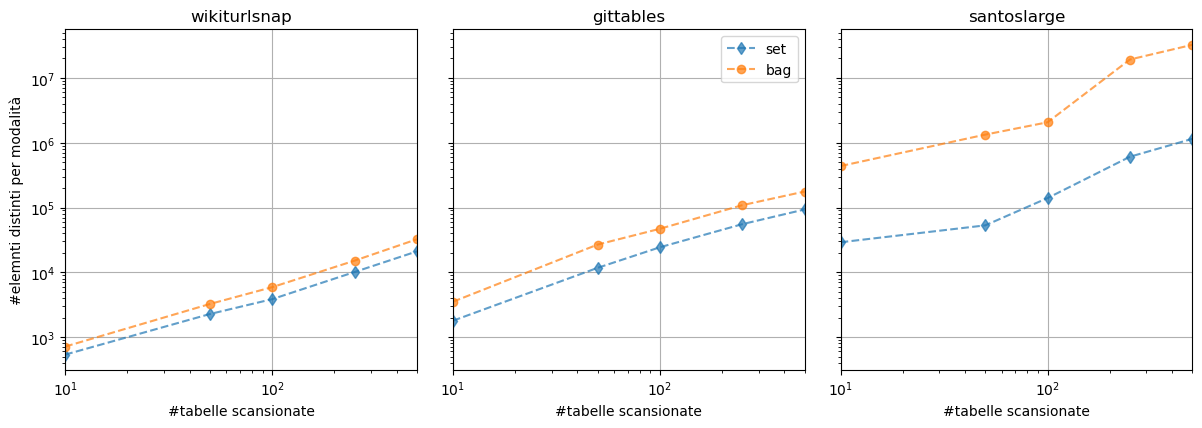

In [64]:
from tools.utils.misc import create_token_set, get_query_ids_from_query_file
from collections import defaultdict, Counter

datasets = [['wikiturlsnap', '50K'], ['gittables', '50K'], ['santoslarge', '500_v1']]
fig, axes = plt.subplots(1, len(datasets), figsize=(12, 4), sharey=True)
fig.tight_layout(w_pad=1)
N = 10 ** 4 + 1



dlhw = SimpleDataLakeHelper('mongodb', 'wikiturlsnap', 'standard')
dlhg = SimpleDataLakeHelper('mongodb', 'gittables', 'standard')
dlhs = SimpleDataLakeHelper("/data4/nanni/data/santos_large/datalake", 'santoslarge', 'standard', "/data4/nanni/data/santos_large/mapping_id.pickle", "/data4/nanni/data/santos_large/numeric_columns.pickle")


for (dataset, qsize), ax, dlh in zip(datasets, axes, [dlhw, dlhg, dlhs]):
    paths = get_all_paths('main', dataset, 20, qsize)
    bins = [10, 50, 100, 250, 500]

    queries = get_query_ids_from_query_file(paths[1])

    for mode, marker in zip(['set', 'bag'], ['--d', '--o']):
        probes = []
        elements = defaultdict(int)
        for i, q in enumerate(queries, start=1):
            if i >= bins[-1] + 1:
                break

            table_obj = dlh.get_table_by_numeric_id(q)
            bag = create_token_set(table_obj['content'], mode, table_obj['numeric_columns'])
            for e, c in Counter(bag).items():
                elements[e] += c

            if i in bins:
                print(i, end='\r')
                probes.append([i, sum(c for _, c in elements.items())])
        x = np.array([p[0] for p in probes])
        y = np.array([p[1] for p in probes])
        
        ax.plot(x, y, marker, label=mode, alpha=0.7)    

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('#tabelle scansionate')
    ax.grid(True)
    ax.set_xlim(min(x), max(x))
    # ax.set_ylim(10 ** 2, 10 ** 6)

    ax.set_title(dataset)

axes[0].set_ylabel('#elemnti distinti per modalità')
axes[1].legend()
plt.show()

## Embedding cosine VS jaccard VS levenshtein

When using embeddings, there are a lot of False Positives, but why?

In [ ]:
import fasttext
import fasttext.FastText
from tools.utils.settings import DefaultPath as dp


ft = fasttext.load_model(f'{dp.model_path.fasttext}/cc.en.300.bin')

In [ ]:
import string
import numpy as np
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords = set(stopwords.words())
punctuation_translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
digits_translator = str.maketrans(string.digits, ' ' * len(string.digits))

In [ ]:
'Hell4,dud3'.translate(punctuation_translator).translate(digits_translator)

In [ ]:
def clean_string(s:str):
    s = s.lower().translate(punctuation_translator).translate(digits_translator)
    tokens = [t for t in s.split() if t not in stopwords]
    # tokens = [t for t in tokens if t not in stopwords]
    return ' '.join(tokens)

clean_string('The DuD3:he was coming,yeah,coming righ7 towards me!At 7:00 am!')

In [ ]:
def embed_string(s:str, embedding_function, embedding_size):
    s = clean_string(s)
    if len(s) == 0:
        return np.zeros((embedding_size, ))
    return embedding_function(s)

embed_string('The DuD3:he was coming,yeah,coming righ7 towards me!At 7:00 am!', ft.get_sentence_vector, ft.get_dimension()).shape

In [ ]:
df = pl.read_csv('/data4/nanni/tesi-magistrale/data/tests/main/wikiturlsnap/results/extracted/final_results_k20_q50K.csv')

In [ ]:
df = df.filter((pl.col('algorithm') == 'embedding') & (pl.col('mode') == 'ft'))
df.sample(10)

In [ ]:
import faiss

faiss.IndexBinaryIVF().add_core

## SLOTH example

In [26]:
from tools.sloth.sloth import sloth
from tools.utils.misc import create_token_set

In [20]:
A = [
    ['cat', 'Snow', 'F'],
    ['dog', 'Rex', 'M'],
    ['cat', 'Ball', 'F'],
    ['fish', 'Ball', 'F']
]

B = [
    ['cat', 'Snow', 2, 'F'],
    ['cat', 'Leo', 4, 'M'],
    ['snake', 'Severus', 13, 'U'],
    ['fish', 'Ball', 2, 'F'],
    ['cat', 'Ball', 4, 'F']
]

In [27]:
Aset = create_token_set(A, 'set', [0, 0, 0])
Abag = create_token_set(A, 'bag', [0, 0, 0])

Bset = create_token_set(B, 'set', [0, 0, 0, 0])
Bbag = create_token_set(B, 'bag', [0, 0, 0, 0])

In [28]:
len(set(Aset).intersection(Bset)), len(set(Abag).intersection(Bbag))

(6, 10)

In [24]:
sloth(A, B)

Detected 12 seed(s) in 0.0004329681396484375 seconds.
Generated 1 candidate(s) in 3.4809112548828125e-05 seconds.
Verified 1 candidate(s) in 7.367134094238281e-05 seconds.
Detected 1 largest overlap(s) in 0.00013399124145507812 seconds.
Size of the detected largest overlap(s): 3 columns, 3 rows, 9 cells.
Total elapsed time: 0.0017254352569580078 seconds.
      0     1     2
0     F     F     F
1  Snow  Ball  Ball
2   cat   cat  fish


([([(0, 0), (3, 3), (2, 4)],
   [('cat', 'cat', 'fish'), ('Snow', 'Ball', 'Ball'), ('F', 'F', 'F')])],
 None)

## Percentage variation of set/bag semantic over the rectangular overlap

In [15]:
test_name, dataset, k, q = 'main', 'wikiturlsnap', 20, '50K'
_, _, _, _, _, _, results_extr_dir, _, _, _ = get_all_paths(test_name, dataset, k, q)
extrres = pl.scan_csv(f'{results_extr_dir}/final_results_k{k}_q{q}.csv').drop_nulls()

extrres = (
    extrres
    .filter((pl.col('sloth_overlap') > 10) & (pl.col('sloth_overlap') < 100))
    .select(['sloth_overlap', 'set_intersection_size', 'bag_intersection_size'])
    .with_columns((pl.col('set_intersection_size') / pl.col('sloth_overlap')).alias('set_variation'))
    .with_columns((pl.col('bag_intersection_size') / pl.col('sloth_overlap')).alias('bag_variation'))
).collect().sample(10000)

extrres

sloth_overlap,set_intersection_size,bag_intersection_size,set_variation,bag_variation
i64,i64,i64,f64,f64
14,5,29,0.357143,2.071429
15,18,26,1.2,1.733333
49,35,52,0.714286,1.061224
13,6,27,0.461538,2.076923
42,40,80,0.952381,1.904762
…,…,…,…,…
16,14,33,0.875,2.0625
35,61,75,1.742857,2.142857
94,129,221,1.37234,2.351064


[-5.0, 0.0, 1, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0]


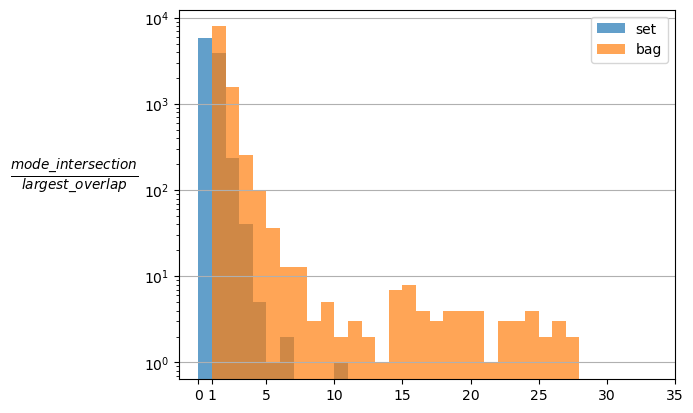

In [41]:
import numpy as np
plt.hist(extrres.select('set_variation'), alpha=0.7, bins=range(0, 30, 1), label='set')
plt.hist(extrres.select('bag_variation'), alpha=0.7, bins=range(0, 30, 1), label='bag')
plt.legend()
xticks, labels = plt.xticks()
xticks = xticks.tolist()
labels.insert(2, 1)
xticks.insert(2, 1)
print(xticks)
plt.xticks(xticks[1:], labels[1:])
plt.grid(axis='y')
plt.ylabel(r'$\frac{mode\_intersection}{largest\_overlap}$', labelpad=50, rotation=0, fontsize=14)
plt.yscale('log')
plt.savefig('/data4/nanni/set_bag_variation.png', bbox_inches='tight')

In [ ]:

extrres = extrres[['query_id', 'bag_size_q']].drop_duplicates()
tot = extrres.shape[0]
r = []


for i in range(len(thresholds)):    
    if i < len(thresholds) - 1:
        s = extrres[(extrres['bag_size_q'] >= thresholds[i]) & (extrres['bag_size_q'] < thresholds[i + 1])].shape[0]
        r.append([f"[{thresholds[i]},{thresholds[i + 1]})", round(s / tot, 5)])
    else:
        s = extrres[(extrres['bag_size_q'] >= thresholds[i])].shape[0]
        r.append([f"[{thresholds[i]},inf)", round(s / tot, 5)])
    # print(f"{thresholds[i]}<=X<{thresholds[i + 1]}:\t{s}\t{s * 100 / tot}")

In [4]:
basicconfig.ALGORITHM_MODE_CONFIG
colors = list(mcolors.TABLEAU_COLORS.keys())
methods = basicconfig.ALGORITHM_MODE_CONFIG
methods = {m: c for m, c in zip(methods, colors[:len(methods)])}

In [17]:
colors

['tab:blue',
 'tab:orange',
 'tab:green',
 'tab:red',
 'tab:purple',
 'tab:brown',
 'tab:pink',
 'tab:gray',
 'tab:olive',
 'tab:cyan']

In [15]:
list(map(lambda am: {'algorithm': am[0], 'mode': am[1]}, methods.keys()))

[{'algorithm': 'josie', 'mode': 'set'},
 {'algorithm': 'josie', 'mode': 'bag'},
 {'algorithm': 'lshforest', 'mode': 'set'},
 {'algorithm': 'lshforest', 'mode': 'bag'},
 {'algorithm': 'embedding', 'mode': 'ft'}]

In [16]:


results = pl.read_csv('/data4/nanni/tesi-magistrale/data/tests/main/santoslarge/results/extracted/final_results_k10_q500.csv')

results = results.filter(pl.struct(['algorithm', 'mode']).is_in(list(map(lambda am: {'algorithm': am[0], 'mode': am[1]}, methods.keys()))))
